<a href="https://colab.research.google.com/github/Godfidence27/CBM_MATERIAL_BALANCE/blob/main/CBM_MATERIAL_BALANCE_Seidle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Enter ONLY these (units shown). Press Enter to accept defaults.
Initial reservoir pressure Pi [psia] [default 600.0]: 700
Final/economic pressure Pf [psia] [default 100.0]: 121
Accessible fraction f [-] (0–1 typical) [default 0.8]: 0.65

Reservoir/coal block (same fields/units as your spec):
area_acres [acres] [default 160.0]: 150
net_thickness_ft [ft] [default 8.0]: 10
coal_bulk_density_ton_per_ft3 [ton/ft^3] [default 0.045]: 
cleat_porosity [-] (e.g., 0.010 = 1%) [default 0.01]: 
T_F [°F] [default 100.0]: 240
sg_gas [-] [default 0.6]: 
sw_initial [-] [default 0.85]: 
c_w [psi^-1] [default 3.2e-06]: 
c_cleat [psi^-1] [default 1e-05]: 
c_matrix_shrink [psi^-1] [default 0.0]: 

[Isotherm prior used] VL and pL were estimated (no lab data).
  VL ≈ 559.4 scf/ton,  pL ≈ 321.8 psia
  Limitation: true values depend strongly on coal rank, moisture, ash, and gas composition.
  Action: replace with lab isotherm at reservoir T when available.

--- CBM Material Balance (Seidle-aligned) ---
Pi=700

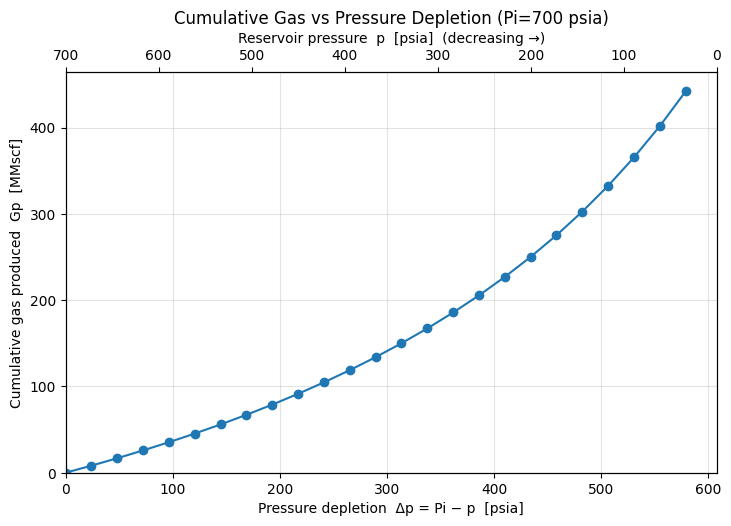

In [ ]:
# Coal Bed Methane Material Balance Simulator
# Author : Mihir Chandra
# Version 4
# Seidle

# ----------------------------------------------------------------
from dataclasses import dataclass
from typing import Sequence, Dict, Any, Optional
import math
import numpy as np
import matplotlib.pyplot as plt

# ---------- constants ----------

ACRE_TO_FT2 = 43_560.0
RB_PER_FT3 = 1.0 / 5.614583333   # 1 reservoir bbl = 5.614583... ft^3
RANKINE_OFFSET = 459.67

# Standard conditions used in Seidle’s Bg definition
PSC = 14.7     # psia
TSC = 520.0    # °R
ZSC = 1.0      # assume ideal at standard conditions

def R(T_F: float) -> float:
    return T_F + RANKINE_OFFSET

def fmt_gas(x: float) -> str:
    ax = abs(x)
    if ax >= 1e9: return f"{x/1e9:.3f} Bscf"
    if ax >= 1e6: return f"{x/1e6:.3f} MMscf"
    return f"{x:,.0f} scf"

def fmt_water(x: float) -> str:
    ax = abs(x)
    if ax >= 1e6: return f"{x/1e6:.3f} MMrb"
    if ax >= 1e3: return f"{x/1e3:.3f} krb"
    return f"{x:,.1f} rb"

def z_ideal(p_psia: float, T_R: float, sg_gas: float) -> float:
    # Light z placeholder; fine for low–moderate CBM pressures. Swap for HY/DAK if needed.
    if p_psia <= 500.0: return 1.0
    return min(1.1, 1.0 + 0.0001 * (p_psia - 500.0))


# ---------- core model ----------

@dataclass
class Langmuir:
    V_L_scf_per_ton: float   # scf/ton
    P_L_psia: float          # psia

    def gas_content(self, p_psia: float) -> float:
        # Seidle Eq. (5.1): V = VL * p / (p + pL)
        if p_psia <= 0.0: return 0.0
        return self.V_L_scf_per_ton * p_psia / (self.P_L_psia + p_psia)

@dataclass
class CBMReservoir:
    area_acres: float
    net_thickness_ft: float
    coal_bulk_density_ton_per_ft3: float
    cleat_porosity: float
    T_F: float

    sg_gas: float = 0.60
    sw_initial: float = 0.85
    c_w: float = 3.2e-6
    c_cleat: float = 1.0e-5
    c_matrix_shrink: float = 0.0
    bw_rb_per_stb: float = 1.0

    def bulk_volume_ft3(self) -> float:
        return self.area_acres * ACRE_TO_FT2 * self.net_thickness_ft

    def cleat_pore_volume_ft3(self) -> float:
        return self.bulk_volume_ft3() * self.cleat_porosity

    def coal_mass_ton(self) -> float:
        return self.bulk_volume_ft3() * self.coal_bulk_density_ton_per_ft3

    @property
    def T_R(self) -> float:
        return R(self.T_F)

@dataclass
class CBMMaterialBalance:
    res: CBMReservoir
    iso: Langmuir
    include_free_gas: bool = True

    # Seidle’s real-gas FVF (Bg) definition:
    # Bg(ft^3/scf) = (psc * Z * T) / (p * Zsc * Tsc)  → convert to rb/scf by dividing 5.61458...
    def Bg_rb_per_scf(self, p_psia: float, Z: float) -> float:
        if p_psia <= 0.0: return float("inf")
        Bg_ft3_per_scf = (PSC * Z * self.res.T_R) / (p_psia * ZSC * TSC)   # Seidle def
        return Bg_ft3_per_scf * RB_PER_FT3

    def adsorbed_gas_scf(self, p_psia: float) -> float:
        # Adsorbed OGIP = gas content (scf/ton) * coal mass (ton)
        return self.iso.gas_content(p_psia) * self.res.coal_mass_ton()

    def free_gas_scf(self, p_psia: float) -> float:
        # Free gas in cleats: PV_g (rb) / Bg(rb/scf)
        if not self.include_free_gas or p_psia <= 0.0: return 0.0
        PVg_ft3 = self.res.cleat_pore_volume_ft3() * max(1.0 - self.res.sw_initial, 0.0)
        PVg_rb = PVg_ft3 * RB_PER_FT3
        z = z_ideal(p_psia, self.res.T_R, self.res.sg_gas)
        Bg = self.Bg_rb_per_scf(p_psia, z)
        if not math.isfinite(Bg) or Bg <= 0.0: return 0.0
        return PVg_rb / Bg

    def total_gas_scf(self, p_psia: float) -> float:
        return self.adsorbed_gas_scf(p_psia) + self.free_gas_scf(p_psia)

    def F_of_p_scf(self, Pi: float, p: float) -> float:
        # Released-from-storage function: F(p) = G_tot(Pi) - G_tot(p)
        return self.total_gas_scf(Pi) - self.total_gas_scf(p)

    def water_withdrawal_rb(self, Pi: float, p: float, include_shrinkage: bool = True) -> float:
        # First-order compressibility water MB (volume to drop from Pi to p)
        if p >= Pi: return 0.0
        PV_i_rb = self.res.cleat_pore_volume_ft3() * RB_PER_FT3
        shrink = self.res.c_matrix_shrink if include_shrinkage else 0.0
        eff_c = max(self.res.c_w + self.res.c_cleat - shrink, 0.0)
        dP = (Pi - p)
        Bw = max(self.res.bw_rb_per_stb, 1e-12)
        return PV_i_rb * self.res.sw_initial * eff_c * dP / Bw


# ---------- Langmuir (V_L, P_L) ----------

def estimate_langmuir_priors(res: CBMReservoir) -> Langmuir:
    """
    Heuristic prior if lab isotherm is unavailable.
    Baseline near ~100°F: VL ≈ 600 scf/ton, pL ≈ 300 psia, with a gentle temperature tilt.
    """
    V0, P0 = 600.0, 300.0
    T = max(res.T_F, 1.0)
    t_ratio = T / 100.0
    V_L = V0 * (1.0 / (t_ratio**0.08))
    P_L = P0 * (t_ratio**0.08)
    V_L = float(np.clip(V_L, 300.0, 1200.0))
    P_L = float(np.clip(P_L, 100.0, 800.0))
    return Langmuir(V_L_scf_per_ton=V_L, P_L_psia=P_L)

def print_prior_warning(iso: Langmuir):
    print("\n[Isotherm prior used] VL and pL were estimated (no lab data).")
    print(f"  VL ≈ {iso.V_L_scf_per_ton:.1f} scf/ton,  pL ≈ {iso.P_L_psia:.1f} psia")
    print("  Limitation: true values depend strongly on coal rank, moisture, ash, and gas composition.")
    print("  Action: replace with lab isotherm at reservoir T when available.\n")


# ---------- prediction & plotting ----------

def predict_gp_curve(mb: CBMMaterialBalance,
                     Pi: float, Pf: float, f_access: float,
                     n_points: int = 25) -> Dict[str, np.ndarray]:
    """
    Tank MB predictor: Gp(p) = f * [G_tot(Pi) - G_tot(p)]
    """
    if not (0.0 <= f_access <= 1.5):
        raise ValueError("f should be 0–1 (use 0–1.5 only for quick what-ifs).")
    if Pf >= Pi:
        raise ValueError("Pf must be < Pi.")
    n_points = max(int(n_points), 2)
    p = np.linspace(Pi, Pf, n_points)   # high → low
    F = np.array([mb.F_of_p_scf(Pi, pi) for pi in p], dtype=float)
    Gp = f_access * F
    dep = Pi - p
    return {"pressure_psia": p, "depletion_psia": dep, "F_scf": F, "Gp_scf": Gp}

def print_summary(mb: CBMMaterialBalance, Pi: float, Pf: float, f_access: float):
    G_ads_i = mb.adsorbed_gas_scf(Pi); G_free_i = mb.free_gas_scf(Pi)
    G_ads_f = mb.adsorbed_gas_scf(Pf); G_free_f = mb.free_gas_scf(Pf)
    G_tot_i = G_ads_i + G_free_i; G_tot_f = G_ads_f + G_free_f
    F_Pf = G_tot_i - G_tot_f
    EUR = f_access * F_Pf
    Wp = mb.water_withdrawal_rb(Pi, Pf, include_shrinkage=True)

    print("--- CBM Material Balance (Seidle-aligned) ---")
    print(f"Pi={Pi:.0f} psia, Pf={Pf:.0f} psia, f={f_access:.2f}")
    print(f"OGIP at Pi: {fmt_gas(G_tot_i)}  (ads={fmt_gas(G_ads_i)}, free={fmt_gas(G_free_i)})")
    print(f"Gas at Pf:  {fmt_gas(G_tot_f)}  (ads={fmt_gas(G_ads_f)}, free={fmt_gas(G_free_f)})")
    print(f"F(Pf):     {fmt_gas(F_Pf)}   →  EUR = f·F(Pf) = {fmt_gas(EUR)}")
    print(f"Water (Pi→Pf): {fmt_water(Wp)}  [compressibility estimate]\n")

def plot_gp_vs_depletion_with_pressure(Pi: float,
                                       pressures_psia: Sequence[float],
                                       Gp_scf: Sequence[float],
                                       use_mmscf: bool = True,
                                       title: Optional[str] = None) -> None:
    p = np.asarray(pressures_psia, dtype=float)
    gp = np.asarray(Gp_scf, dtype=float)
    dep = Pi - p
    idx = np.argsort(dep)
    dep, p, gp = dep[idx], p[idx], gp[idx]
    scale = 1e6 if use_mmscf else 1.0
    unit = "MMscf" if use_mmscf else "scf"

    fig, ax = plt.subplots(figsize=(8.4, 5.2))
    ax.plot(dep, gp/scale, marker="o")
    if not title: title = f"Cumulative Gas vs Pressure Depletion (Pi={Pi:.0f} psia)"
    ax.set_title(title)
    ax.set_xlabel("Pressure depletion  Δp = Pi − p  [psia]")
    ax.set_ylabel(f"Cumulative gas produced  Gp  [{unit}]")
    ax.grid(True, alpha=0.35)
    ax.set_xlim(left=0); ax.set_ylim(bottom=0)
    ax.ticklabel_format(style="plain", axis="both", useOffset=False)

    # top axis: pressure labels at the same ticks (p = Pi − Δp)
    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())
    xt = ax.get_xticks()
    ax_top.set_xticks(xt)
    ax_top.set_xticklabels([f"{(Pi - x):.0f}" for x in xt])
    ax_top.set_xlabel("Reservoir pressure  p  [psia]  (decreasing →)")
    plt.show()


# ---------- interactive main ----------

def ask_float(prompt: str, default: Optional[float] = None, lo: Optional[float] = None, hi: Optional[float] = None) -> float:
    while True:
        s = input(f"{prompt}" + (f" [default {default}]" if default is not None else "") + ": ").strip()
        if not s and default is not None:
            x = float(default)
        else:
            try: x = float(s)
            except ValueError:
                print("  Please enter a number."); continue
        if (lo is not None and x < lo) or (hi is not None and x > hi):
            lo_s = "-∞" if lo is None else f"{lo}"
            hi_s = "+∞" if hi is None else f"{hi}"
            print(f"  Out of range ({lo_s}..{hi_s})."); continue
        return x

def ask_yesno(prompt: str, default: bool = True) -> bool:
    d = "Y/n" if default else "y/N"
    while True:
        s = input(f"{prompt} [{d}]: ").strip().lower()
        if not s: return default
        if s in ("y","yes"): return True
        if s in ("n","no"): return False
        print("  Please answer y or n.")

if __name__ == "__main__":
    print("\nEnter ONLY these (units shown). Press Enter to accept defaults.")
    # (1) Pressures & accessible fraction f
    Pi = ask_float("Initial reservoir pressure Pi [psia]", default=600.0, lo=1.0)
    Pf = ask_float("Final/economic pressure Pf [psia]", default=100.0, lo=0.0, hi=Pi-1e-6)
    f_access = ask_float("Accessible fraction f [-] (0–1 typical)", default=0.80, lo=0.0, hi=1.5)

    # (2) Reservoir/coal block (your exact fields/units)
    print("\nReservoir/coal block (same fields/units as your spec):")
    area_acres = ask_float("area_acres [acres]", default=160.0, lo=1e-6)
    net_thickness_ft = ask_float("net_thickness_ft [ft]", default=8.0, lo=1e-6)
    coal_bulk_density_ton_per_ft3 = ask_float("coal_bulk_density_ton_per_ft3 [ton/ft^3]", default=0.045, lo=1e-6)
    cleat_porosity = ask_float("cleat_porosity [-] (e.g., 0.010 = 1%)", default=0.010, lo=0.0, hi=0.5)
    T_F = ask_float("T_F [°F]", default=100.0)
    sg_gas = ask_float("sg_gas [-]", default=0.60, lo=0.3, hi=1.5)
    sw_initial = ask_float("sw_initial [-]", default=0.85, lo=0.0, hi=1.0)
    c_w = ask_float("c_w [psi^-1]", default=3.2e-6, lo=0.0)
    c_cleat = ask_float("c_cleat [psi^-1]", default=1.0e-5, lo=0.0)
    c_matrix_shrink = ask_float("c_matrix_shrink [psi^-1]", default=0.0, lo=0.0)

    res = CBMReservoir(
        area_acres=area_acres,
        net_thickness_ft=net_thickness_ft,
        coal_bulk_density_ton_per_ft3=coal_bulk_density_ton_per_ft3,
        cleat_porosity=cleat_porosity,
        T_F=T_F,
        sg_gas=sg_gas,
        sw_initial=sw_initial,
        c_w=c_w,
        c_cleat=c_cleat,
        c_matrix_shrink=c_matrix_shrink,
        bw_rb_per_stb=1.0
    )

    # Auto-calc Langmuir from a heuristic prior
    iso = estimate_langmuir_priors(res)
    print_prior_warning(iso)

    # Build MB model & predict
    mb = CBMMaterialBalance(res=res, iso=iso, include_free_gas=True)
    pred = predict_gp_curve(mb, Pi, Pf, f_access=f_access, n_points=25)

    # Report & plot
    print_summary(mb, Pi, Pf, f_access)
    plot_gp_vs_depletion_with_pressure(Pi, pred["pressure_psia"], pred["Gp_scf"], use_mmscf=True)
